In [16]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import seaborn as sns
import os, re, time
import matplotlib.pyplot as plt
from scipy import stats
#%matplotlib inline

sns.set(color_codes=True)

CLASS_LABELS = ['slowest', 'slow', 'middle', 'fast', 'fastest']
DATA_SET_DIR = '/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/FEATURE_ANALYSIS/'
def mkdirs(dir_paths):
    for dir_path in dir_paths:
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
ORIGIN_DATA_DIR = os.path.join(DATA_SET_DIR, 'ORIGIN_DATA')
CLASSIFIED_DATA_DIR = os.path.join(DATA_SET_DIR, 'CLASSIFIED_DATA')
ChrmoHMM_DIR = os.path.join(DATA_SET_DIR, 'ChrmoHMM_INTERSECTED')
ChrmoHMM_LABELS="Active Promoter","Weak Promoter","Poised Promoter","Strong Enhancer","Strong Enhancer","Weak Enhancer","Weak Enhancer","Insulator","Txn Transition","Txn Elongation","Weak Txn","Repressed","Heterochrom/lo","Repetitive/CNV","Repetitive/CNV"

HISTONE_DIR = os.path.join(DATA_SET_DIR, 'HISTONE_INTERSECTED')
HISTONE_TYPES = ["H3K4me1", "H3K4me3", "H3K9Me3", "H3K27ac", "H3K27Me3", "H3K36me3"]

mkdirs([ORIGIN_DATA_DIR, CLASSIFIED_DATA_DIR])

Tile_window_szs = [2, 100, 500, 1000]  # 50, 100, 200, 500, 1000, 2000, 5000
TILE_LABLES = ['Site K', 'Tile 100bp', 'Tile 500bp', 'Tile 1000bp'] # 'Tile 200bp',, 'Tile 2000bp'
REPLIS = [1, 41]
EACH_SUB_FIG_SIZE = 8
N_CLASSES = len(CLASS_LABELS)
NUMBER_OF_CHRMM_CLASS = 15
percentile_names = [str(i*20) for i in range(1, N_CLASSES + 1)]
CHROMOSOMES = [i for i in range(1, 23)]

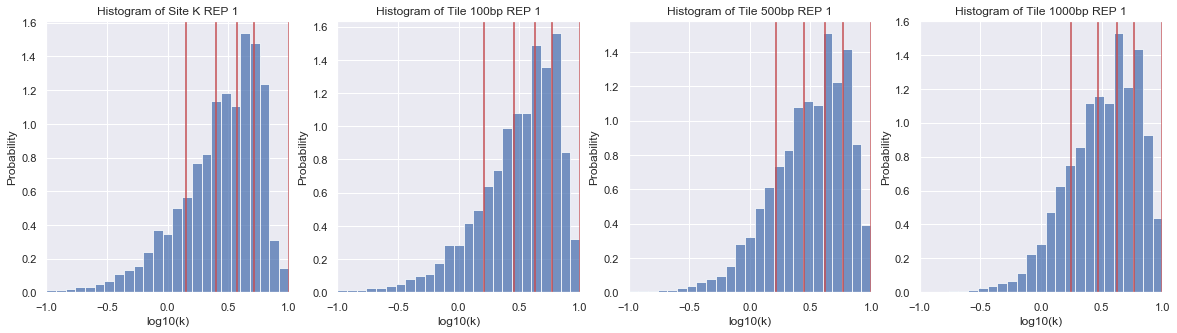

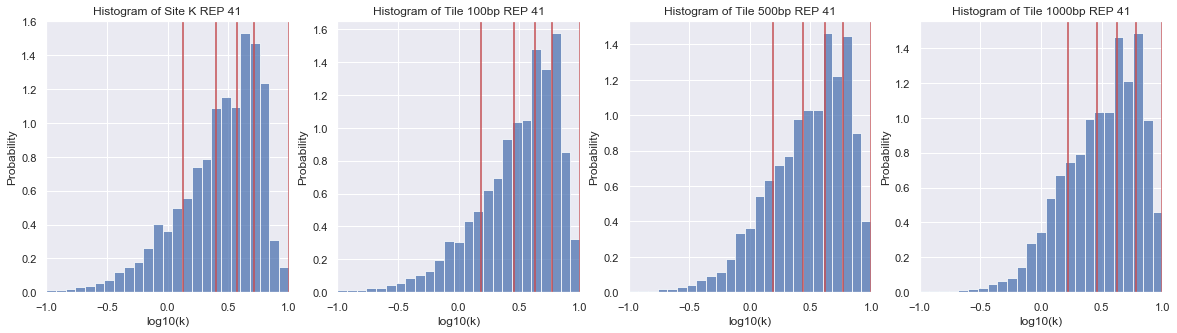

In [26]:
def plot_5_classes_of_K_by_histogram():
    for repli in REPLIS:
        repli_dir = os.path.join(ORIGIN_DATA_DIR, "Rep" + str(repli))
        classified_repli_dir = os.path.join(CLASSIFIED_DATA_DIR, "Rep" + str(repli))
        mkdirs([repli_dir, classified_repli_dir])
        k_arr = []
        percs = []
        for tile_window_sz in Tile_window_szs:
            file_name = 'tile_' + str(tile_window_sz)
            f_path = os.path.join(repli_dir, file_name + ".csv")
            df = pd.read_csv(f_path, sep=',', header=None).values

            ks = df[:, 2]
            ks[ks <= 0] = 0.001
            ks = np.log10(ks)
            df[:, 2] = ks

            percentiles = [-2.0]
            percentile_names = []
            for i in range(1, N_CLASSES + 1):
                percentile = i * 20
                percentile_names.append(str(percentile))
                percentiles.append(float(np.percentile(ks, percentile)))
            percs.append(percentiles[1:])
            #         class_datas = []
            #             for p_idx in range(0, N_CLASSES):
            #                 df_indexs = np.logical_and(ks > percentiles[p_idx], ks < percentiles[p_idx + 1])
            #                 class_datas.append(df[df_indexs, :])

            #             for c_i, class_data in enumerate(class_datas):
            #                 (row_len, col_len) = class_data.shape
            #                 bed_data = np.zeros((row_len, col_len + 1))
            #                 bed_data[:, [0, 1, 3]] = class_data
            #                 bed_data[:, 2] = class_data[:, 1] + 1
            #                 out_fp = os.path.join(classified_repli_dir, file_name + "_" + CLASS_LABELS[c_i] + '.bed')
            #                 np.savetxt(out_fp, bed_data[:, :], fmt="chr%d\t%d\t%d\t%.4f", delimiter='\n')
            #                 print("finish %s" % out_fp)
            k_arr.append(ks)

        fig, axs = plt.subplots(1, len(Tile_window_szs),
                                figsize=(len(Tile_window_szs) * EACH_SUB_FIG_SIZE, EACH_SUB_FIG_SIZE))
        for tile_idx, tile_window_sz in enumerate(Tile_window_szs):
            ax = axs[tile_idx]
            ax.hist(k_arr[tile_idx], 50, density=True, facecolor='b', alpha=0.75)
            for percentile in percs[tile_idx]:
                ax.axvline(x=percentile, color='r')
            ax.set_xlabel('log10(k)')
            ax.set_ylabel('Probability')
            ax.set_title('Histogram of ' + TILE_LABLES[tile_idx] + " REP " + str(repli))
            ax.set_xlim(-1, 1)
        plt.savefig("../FIGURES/FEATURE_ANALYSIS/Hist_" + str(repli) + ".png", dpi=200)

In [3]:
ChrmoHMM_DIR = os.path.join(DATA_SET_DIR, 'ChrmoHMM_INTERSECTED')

In [58]:
def barplot_of_ChrMM_for_each_k_categories():
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')
    for repli in REPLIS:
        repli_dir = os.path.join(ChrmoHMM_DIR, "Rep" + str(repli))

        fig, axs = plt.subplots(1, len(Tile_window_szs),figsize=(len(Tile_window_szs) * EACH_SUB_FIG_SIZE, EACH_SUB_FIG_SIZE))

        for tid, tile_window_sz in enumerate(Tile_window_szs):
            ax = axs[tid]
            width = 0.35
            ind = np.arange(len(CLASS_LABELS))
            chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)
            class_data = np.zeros((len(chrHMMs), len(ind)))
            for cid, class_label in enumerate(CLASS_LABELS):
                file_name = 'tile_' + str(tile_window_sz) + "_" + class_label
                f_path = os.path.join(repli_dir, file_name + ".csv")
                df = pd.read_csv(f_path, sep=',', header=None).values
                classes = df[:, 3]
                unique, counts = np.unique(classes, return_counts=True)
                unique=unique.astype(int)
                normed_counts = counts/float(counts.sum())
                unique_dc = dict(zip(unique, normed_counts))
                for cls in chrHMMs:
                    class_data[cls][cid] = unique_dc[cls+1]
            pls = []
            for cls in chrHMMs:
                if cls == 0:
                    pl = ax.bar(ind, tuple(list(class_data[cls, :])), width)
                else:
                    sum_prev= list(np.sum(class_data[0 : cls, :], axis = 0))
                    pl = ax.bar(ind, tuple(list(class_data[cls, :])), width, bottom=tuple(sum_prev))
                for item in pl:
                    item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
                pls.append(pl)
            ax.set_xlabel('ChromHMM Class')
            ax.set_ylabel('Percentage')
            ax.set_xticklabels(MCLASS_LABELS)
            ax.set_yticks(np.arange(0.2, 1.1, 0.2))
            ax.set_title(TILE_LABLES[tid] + " REP " + str(repli))
            if tid == 0:
                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.7, box.height])
                ax.legend(tuple(pls), tuple(ChrmoHMM_LABELS), loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig("../FIGURES/FEATURE_ANALYSIS/BARPLOT_" + str(repli) + ".png", dpi=200)

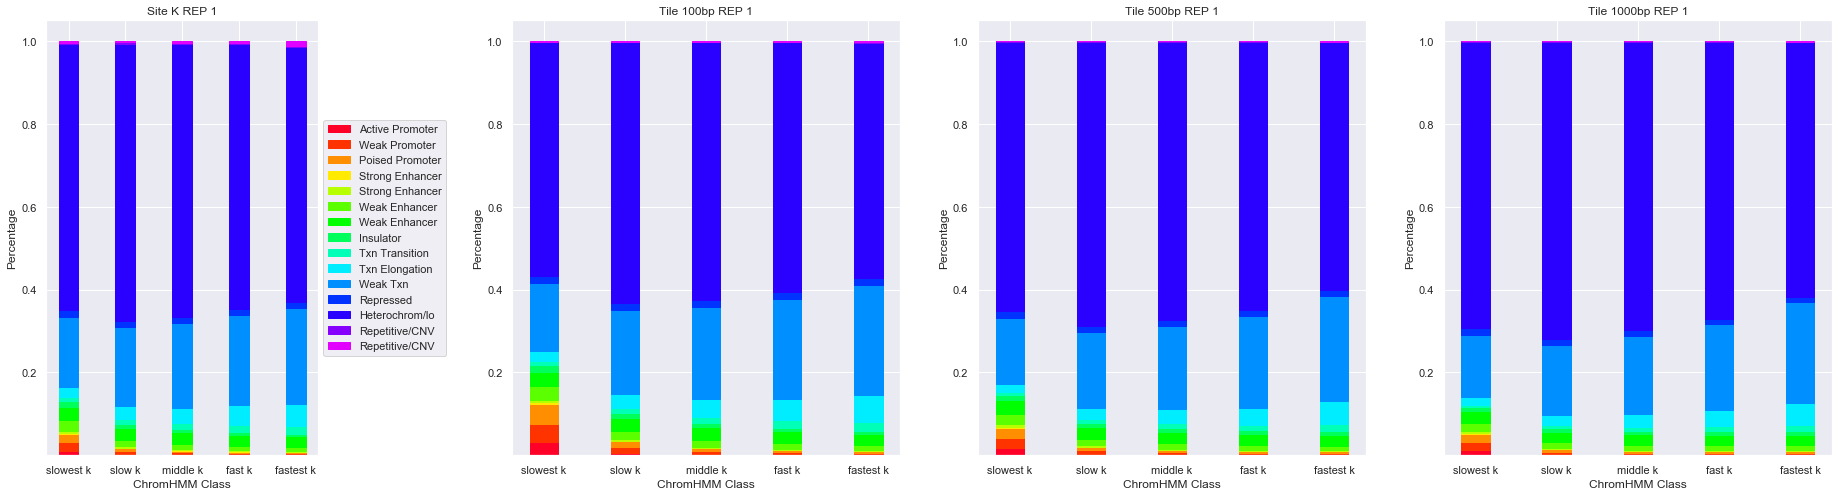

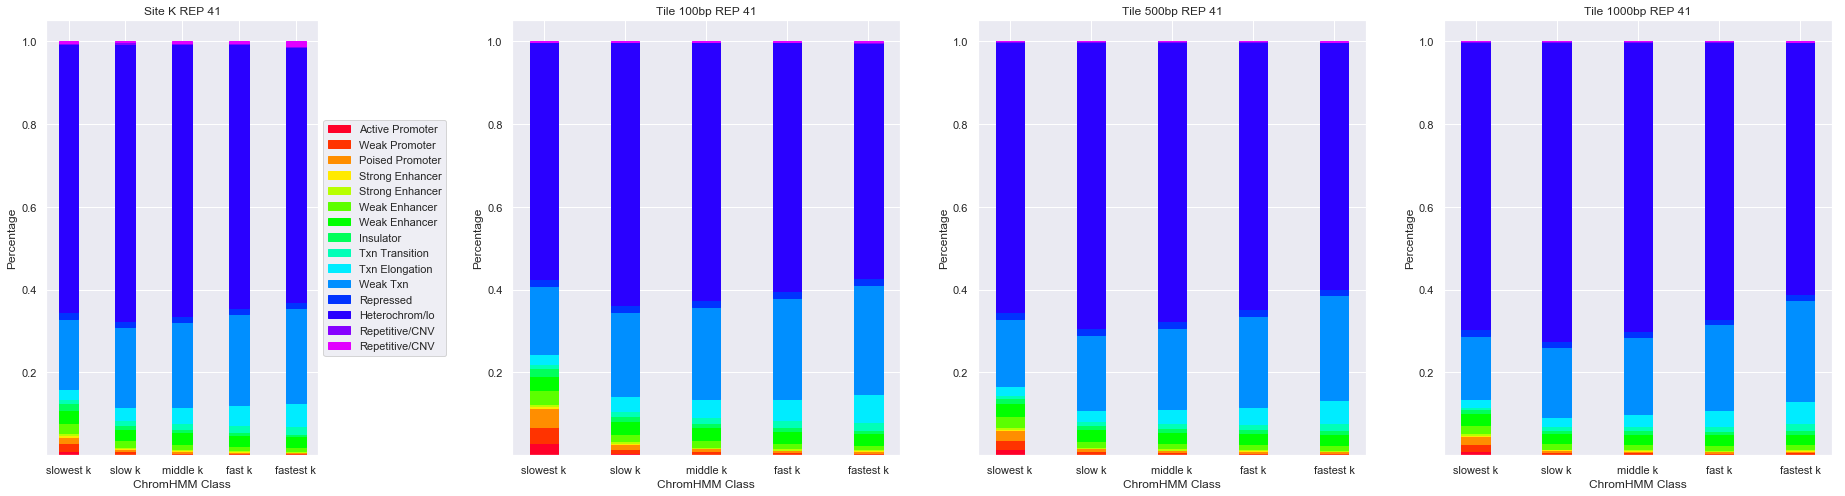

In [59]:
barplot_of_ChrMM_for_each_k_categories()

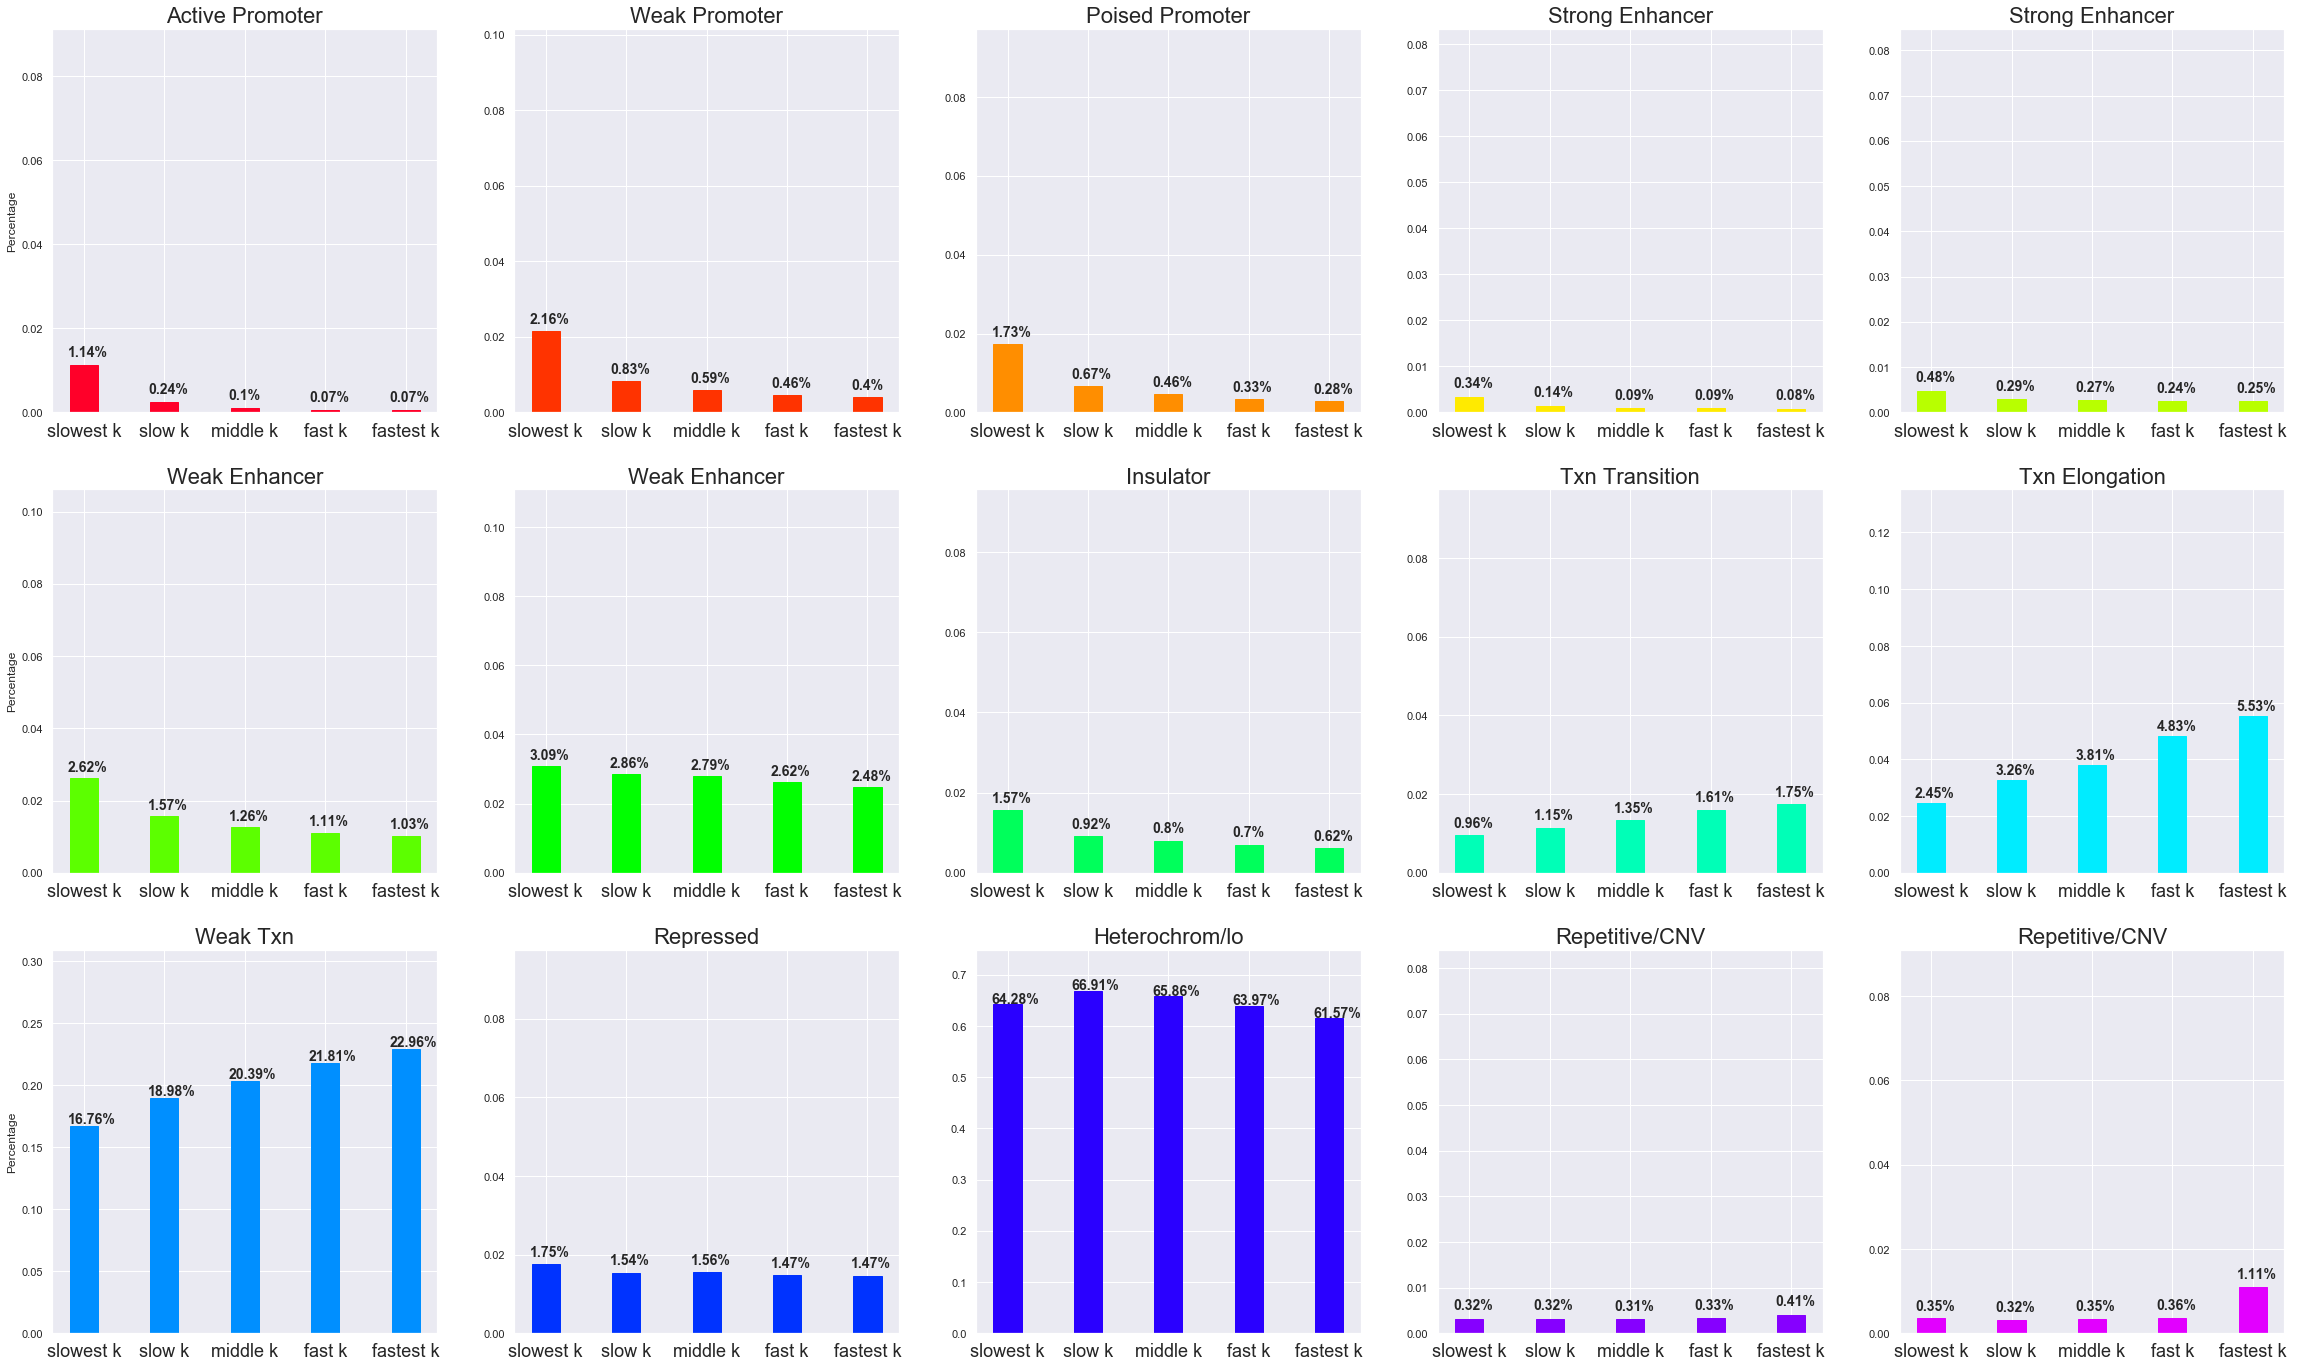

In [14]:
def barplot_of_ChrMM_for_each_k_categories_separately():
    MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
    cm = plt.get_cmap('gist_rainbow')
    repli = 1
    repli_dir = os.path.join(ChrmoHMM_DIR, "Rep" + str(repli))
    N_ROW = 3
    N_COL = 5
    fig, axs = plt.subplots(N_ROW, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))

    ind = np.arange(len(CLASS_LABELS))
    chrHMMs = np.arange(NUMBER_OF_CHRMM_CLASS)
    class_data = np.zeros((len(chrHMMs), len(ind)))

    for cid, class_label in enumerate(CLASS_LABELS):
        file_name = "tile_2_" + class_label
        f_path = os.path.join(repli_dir, file_name + ".csv")
        df = pd.read_csv(f_path, sep=',', header=None).values
        classes = df[:, 3]
        unique, counts = np.unique(classes, return_counts=True)
        unique = unique.astype(int)
        normed_counts = counts / float(counts.sum())
        unique_dc = dict(zip(unique, normed_counts))
        for cls in chrHMMs:
            class_data[cls][cid] = unique_dc[cls + 1]

    for cls in chrHMMs:
        row = int(cls / N_COL)
        col = int(cls % N_COL)
        ax = axs[row][col]
        y_max = np.max(class_data[cls, :]) + 0.08
        pl = ax.bar(ind, tuple(list(class_data[cls, :])), 0.35)
        for item in pl:
            item.set_color(cm(1. * cls / NUMBER_OF_CHRMM_CLASS))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[cls, cid] + 0.002, str(round(class_data[cls, cid] * 100.0, 2)) + "%", fontsize= 14, weight="bold")
        if col == 0:
            ax.set_ylabel('Percentage')
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18)
        ax.set_ylim(0, y_max)
        ax.set_title(ChrmoHMM_LABELS[cls], fontsize=22)
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/ChromHMM_Rep" + str(repli) + "_SEP.png", dpi=200)

<Figure size 360x360 with 0 Axes>

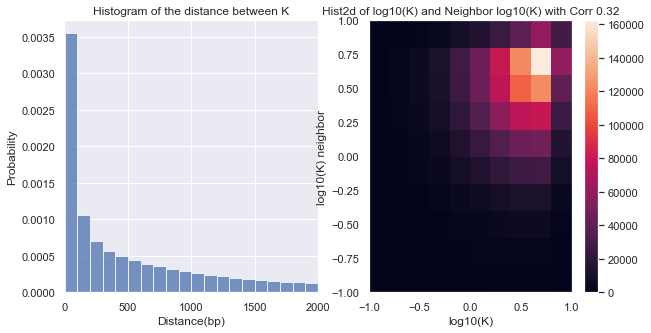

In [110]:
def plot_hist_of_distances_between_ks():
    MAX_DIST = 2000
    data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep1', 'tile_2.csv')
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    ks[ks <= 0] = 0.001
    df[:, 2] = np.log10(ks)
    dists = np.array([])
    K_pairs = np.array([])
    for chr_i in CHROMOSOMES:
        chr_indexs = df[:, 0].astype(int) == chr_i
        df_chr = df[chr_indexs, 1]
        ds = df_chr[1:] - df_chr[0:-1]
        dists = np.concatenate((dists, ds), axis=0) if dists.size != 0 else ds

        k_arr = df[chr_indexs, 2].reshape(-1,1)
        kps = np.concatenate((k_arr[0:-1], k_arr[1:]), axis=1)
        K_pairs = np.concatenate((K_pairs, kps), axis=0) if K_pairs.size != 0 else kps

    dists = dists[dists < MAX_DIST]
    corr_coef = np.corrcoef(K_pairs[:, 0], K_pairs[:, 1])[0][1]

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    ax = axs[0]
    ax.hist(dists, 20, density=True, facecolor='b', alpha=0.75)
    ax.set_xlabel('Distance(bp)')
    ax.set_ylabel('Probability')
    ax.set_xlim(0, MAX_DIST)
    ax.set_title("Histogram of the distance between K")

    ax2 = axs[1]
    ax2.hist2d(K_pairs[:, 0], K_pairs[:, 1],bins=20)
    ax2.set_xlabel('log10(K)')
    ax2.set_ylabel('log10(K) neighbor')
    ax2.set_xlim(-1, 1)
    ax2.set_ylim(-1, 1)
    ax2.set_title("Hist2d of log10(K) and Neighbor log10(K) with Corr " + str(round(float(corr_coef), 2)))

    plt.savefig("../FIGURES/FEATURE_ANALYSIS/Hist_of_Distance.png", dpi=200)

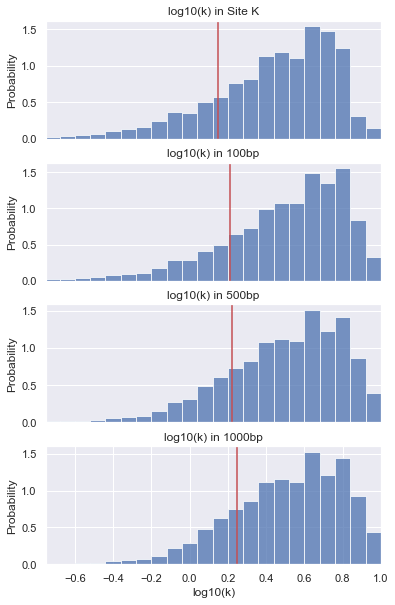

In [99]:
def hist_for_logk_distribution():
    fig, axs = plt.subplots(4, 1, figsize=(6, 8))
    # ind = np.arange(len(Tile_window_szs))
    # logk_arr = []
    for tid, tile_window_sz in enumerate(Tile_window_szs):
        data_fp = os.path.join(ORIGIN_DATA_DIR, 'Rep1', 'tile_' + str(tile_window_sz) + '.csv')
        df = pd.read_csv(data_fp, sep=',', header=None).values
        ks = df[:, 2]
        ks[ks <= 0] = 0.001
        ks = np.log10(ks)
        ax = axs[tid]
        ax.hist(ks, 20, density=True, facecolor='b', alpha=0.75)
        ax.axvline(x=np.percentile(ks, 20), color='r')
        ax.set_ylabel('Probability')
        ax.set_xlim(-0.75, 1)
        ax.set_title("log10(k) in " + TILE_LABLES[tid])
        if tid!=len(Tile_window_szs) - 1:
            ax.set_xticks([])
        else:
            ax.set_xlabel('log10(k)')
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/VIOLIN_PLOT.png", dpi=200)

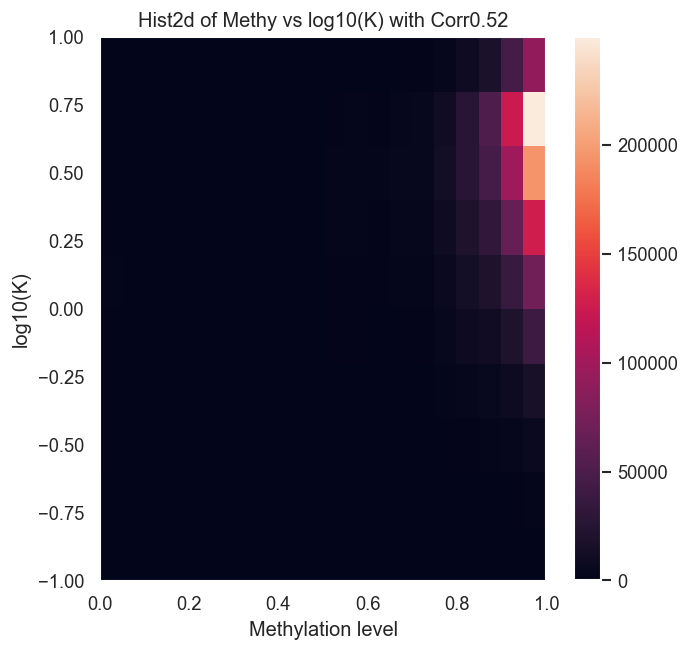

In [108]:
def plot_for_logk_and_methy():
    plt.figure(num=1, figsize=(6, 6), dpi=120)
    data_fp = "/Users/emmanueldollinger/PycharmProjects/prediction_by_k/DATA/Preprocessing/merged_k_and_methy.csv"
    df = pd.read_csv(data_fp, sep=',', header=None).values
    ks = df[:, 2]
    methys = df[:, 3]
    ks[ks <= 0] = 0.001
    ks = np.log10(ks)
    corr_coef = np.corrcoef(ks,methys)[0][1]
    h = plt.hist2d(methys, ks,bins=20)
    plt.colorbar(h[3])
    plt.xlabel('Methylation level')
    plt.ylabel('log10(K)')
    plt.ylim(-1, 1)
    plt.xlim(0, 1)
    plt.title("Hist2d of Methy vs log10(K) with Corr" + str(round(float(corr_coef), 2)))
    plt.savefig("../FIGURES/FEATURE_ANALYSIS/METHY_VS_K.png", dpi=200)

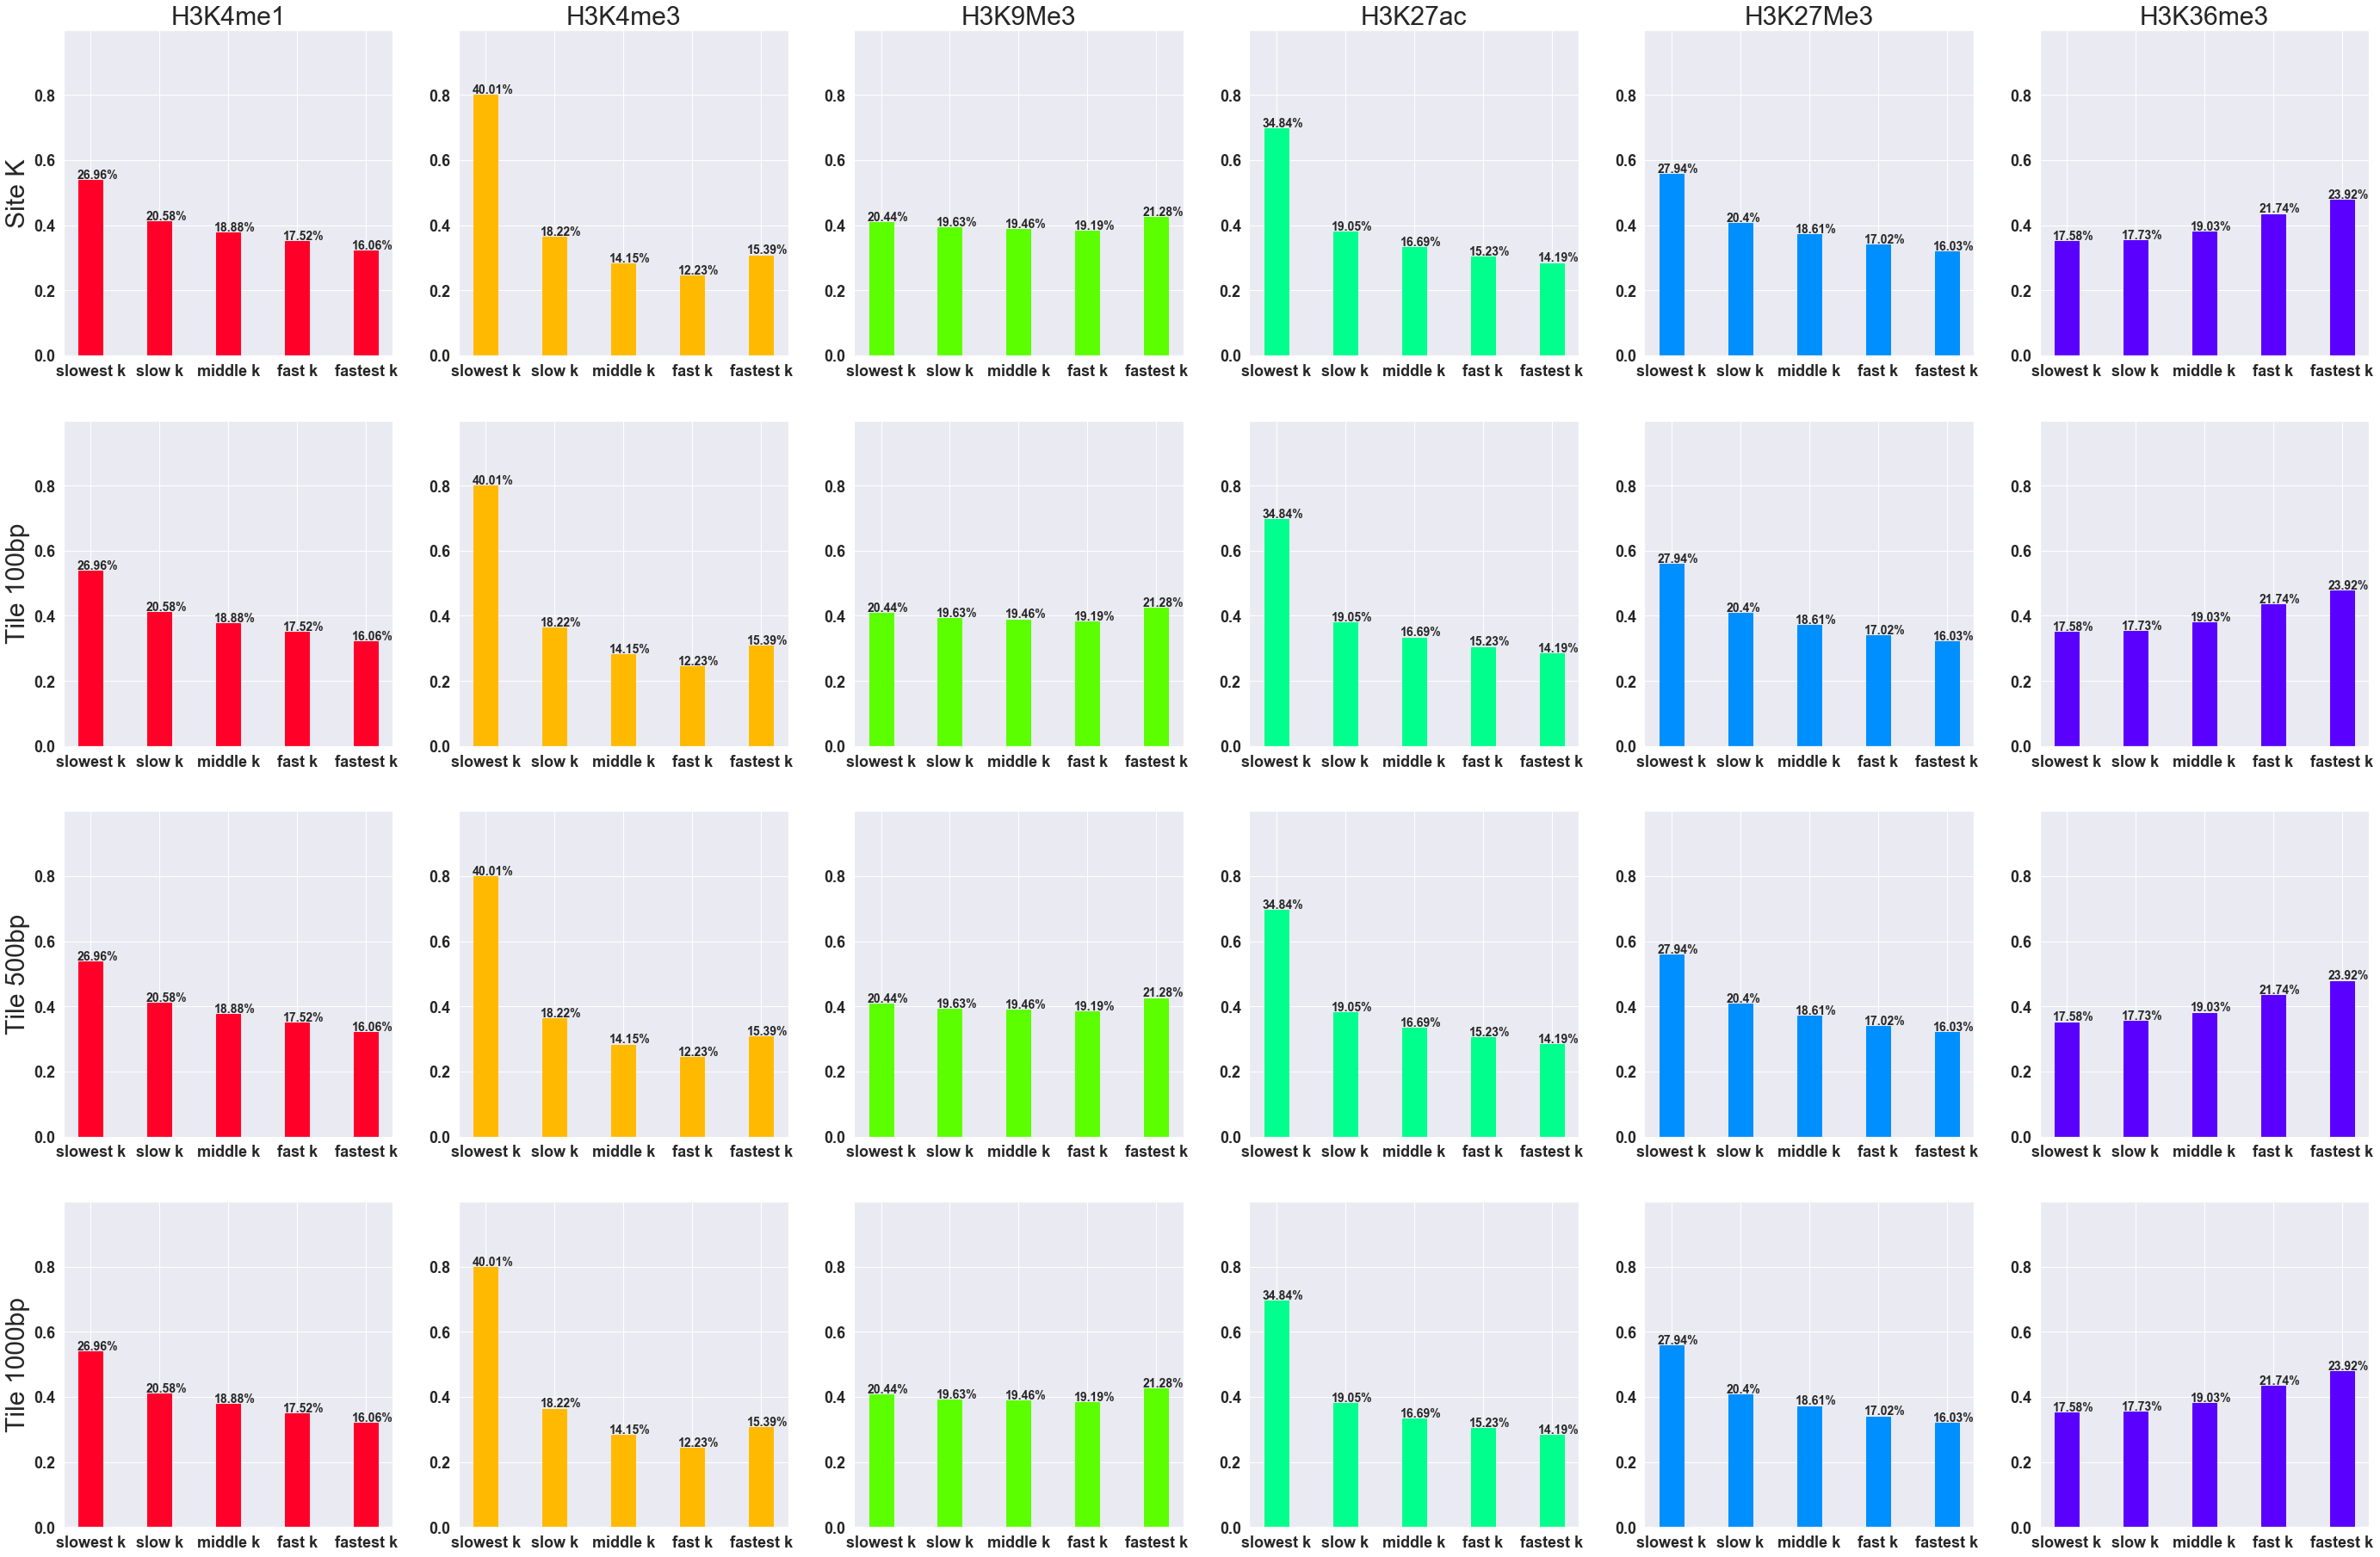

In [30]:
MCLASS_LABELS = ['empty', 'slowest k', 'slow k', 'middle k', 'fast k', 'fastest k']
cm = plt.get_cmap('gist_rainbow')
repli = 1
N_ROW = len(Tile_window_szs)
N_COL = len(HISTONE_TYPES)
fig, axs = plt.subplots(N_ROW, N_COL,figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
for tid, tile_window_sz in enumerate(Tile_window_szs):

    for hid, histone in enumerate(HISTONE_TYPES):
        repli_dir = os.path.join(HISTONE_DIR, histone, "Rep" + str(repli))

        ind = np.arange(len(CLASS_LABELS))
        class_data = np.zeros((len(HISTONE_TYPES), len(ind)))
        sum_n = 0. #sum_of_the_number_of_ks
        for cid, class_label in enumerate(CLASS_LABELS):
            file_name = "tile_2_" + class_label
            f_path = os.path.join(repli_dir, file_name + ".csv")
            df = pd.read_csv(f_path, sep=',', header=None).values
            k_counts = df[:, 2].shape[0]
            sum_n += k_counts
            class_data[hid, cid] = k_counts
        class_data[hid, :] /= sum_n

        ax = axs[tid][hid]
        pl = ax.bar(ind, tuple(list(class_data[hid, :])), width=0.35)

        for item in pl:
            item.set_color(cm(1. * hid / len(HISTONE_TYPES)))
        for cid, class_label in enumerate(CLASS_LABELS):
            ax.text(ind[cid] - 0.2, class_data[hid, cid] + 0.002,
                    str(round(class_data[hid, cid] * 100.0, 2)) + "%", fontsize=14, weight="bold")
        if hid == 0: #Col 1
            ax.set_ylabel(TILE_LABLES[tid], fontsize=30)
        if tid == 0: #Row 1
            ax.set_title(histone, fontsize=30)
        ax.set_xticklabels(MCLASS_LABELS, fontsize=18, weight="bold")
        ax.set_yticklabels([str(round(i*0.2, 1)) for i in range(5)], fontsize=18, weight="bold")
        ax.set_ylim(0, 0.5)
plt.savefig("../FIGURES/FEATURE_ANALYSIS/Histone_Rep" + str(repli) + ".png", dpi=200)